# 2.2. Logistische Regression

>## <ins>Table of contents</ins>
>* [**2.2.1. Klassifikation und Logistische Regression**](#klassifikation)
    * [**Die Logistische Regression (Sigmoid-Funktion)**](#lr)
    * [**Kostenfunktion L<sub>logit</sub>(D, f)**](#L_logit)
>* [**2.2.2. Evaluation**](#evaluation)
>* [**2.2.3. Mehrklassenklassifizierung**](#mehrklassenklassifizierung)
>* [**2.2.4. Nicht-lineare Modelle**](#nl_modelle)
>* [**2.2.5. Andere Beispiele**](#beispiele)
>* [**2.2.6. Zusammenfassung**](#zusammenfassung)
>*  * [**Für einen 2D-Modell**](#2d)
    * [**Für einen 3D-Modell**](#3d)
>   * [**Mehklassenklassifikation**](#mkk)

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt


## 2.2.1. Klassifikation und Logistische Regression <a name="klassifikation"></a>

Sowohl bei der Regression als auch bei der Klassifikation geht es darum, eine Funktion **f** (mit f(x<sup>(i)</sup>) ≈ y<sup>(i)</sup>, i=1,..., m), zu lernen, die Eingaben (Trainingsdatensatz) auf Ausgaben abbildet. Der Hauptunterschied besteht in der Art der Ausgabe:

- Bei der **Regression** ist die Ausgabe kontinuierlich. Das bedeutet, dass die Ausgabe irgendeinen numerischen Wert annehmen kann. Ein Beispiel wäre die Vorhersage des Preises eines Hauses basierend auf Merkmalen wie Größe, Lage, Anzahl der Zimmer usw.

- Bei der **Klassifikation** ist die Ausgabe diskret, oft binär. Das bedeutet, dass die Ausgabe einen von mehreren diskreten Werten annehmen kann. Ein Beispiel wäre die Vorhersage, ob eine E-Mail Spam ist oder nicht (zwei Klassen), oder die Vorhersage der Art einer Blume basierend auf Merkmalen wie Blütenblattlänge und -breite (mehrere Klassen).

In beiden Fällen verwenden wir einen Trainingsdatensatz (Trainingsdatensatz D = {(x<sup>(1)</sup>, y<sup>(1)</sup>),...,(x<sup>(m)</sup>, y<sup>(m)</sup>)}), um die Funktion zu lernen. Der Trainingsdatensatz besteht aus Paaren von Eingaben und der zugehörigen Ausgabe. Wir versuchen, eine Funktion zu finden, die die Eingaben so genau wie möglich auf die Ausgaben abbildet. Nachdem die Funktion gelernt wurde, kann sie verwendet werden, um die Ausgabe für neue, ungesehene Eingaben vorherzusagen.

>**Bei der Klassifikation besteht also die Aufgabe, einen Datenpunkt einer bestimmten Klasse
zuzuweisen.**

**Beispiel 1.**
Sie sind Obstproduzent und möchten Ihren jährlichen Umsatz maximieren, indem Sie Ihr Produkt (den 
fiktiven Rapidapfel) so fü¨h wie ö¨glich ernten. Sie nehmen eine Reihe von Proben nach verschiedenen Tagen un 
testen, ob der Rapidapfel genießbar (Klasse 1) oder (noch) ungenießbar (Klasse 0) istWir nennen diesen Datensatz **D_rapid**.id.

In [2]:
# Create a pandas DataFrame
D_rapid = pd.read_csv("./uebung_2_2/sl_logreg_ex_rapid.csv")

'''
.reshape(-1, 1) changes the shape of the array to have as many rows as needed and 1 column. 
This is often used when you have a 1D array but a function requires a 2D array as input.
'''
x = D_rapid["age"].to_numpy().reshape(-1, 1)
y = D_rapid["edible"].to_numpy()

# Print the DataFrame
print(D_rapid)

   age  edible
0    5       0
1   14       1
2   10       1
3    7       1
4    2       0
5    1       0
6    9       1
7    8       0
8    3       0
9   13       1


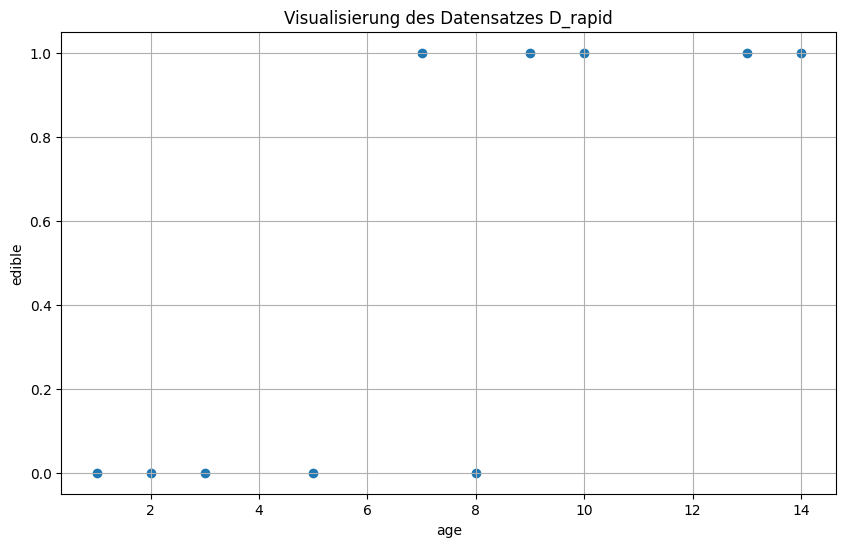

In [3]:
# Datensatz visualisieren

plt.figure(figsize=(10, 6))
plt.scatter(D_rapid['age'], D_rapid['edible'])
plt.title('Visualisierung des Datensatzes D_rapid')
plt.xlabel('age')
plt.ylabel('edible')
plt.grid(True)
plt.show()

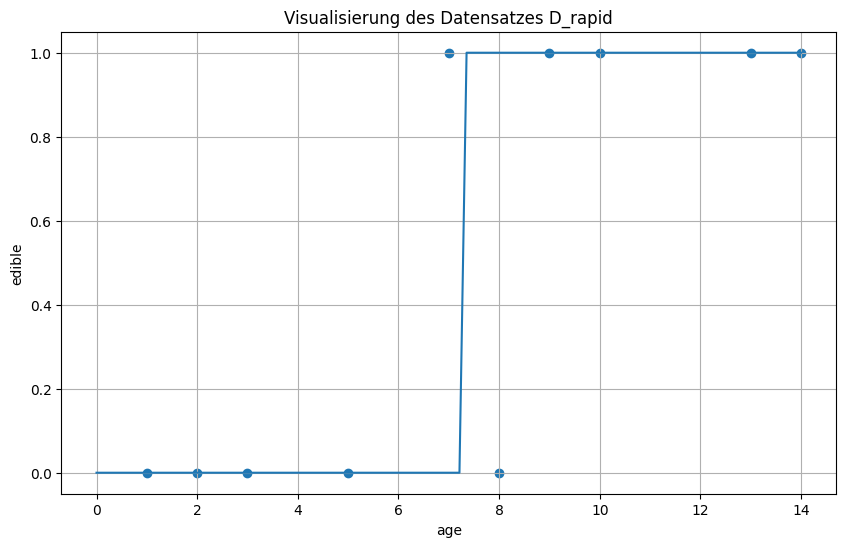

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
model = clf.fit(x,y)

xpts = np.linspace(0, 14, 100)


y_predictions = clf.predict(x)


predictions = model.predict(xpts.reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.scatter(D_rapid['age'], D_rapid['edible'])
plt.plot(xpts, predictions)
plt.title('Visualisierung des Datensatzes D_rapid')
plt.xlabel('age')
plt.ylabel('edible')
plt.grid(True)
plt.show()

### Logistische Regression <a name="lr"></a>
Wir schauen uns nun ein einfaches Modell und den dazugehörigen Lernalgorithmus für binäre Klassifikation an: **die logistische Regression**. 
> Trotz ihres Namens ist die logistische Regression eine Methode zur Klassifikation (und nicht zur Regression).

Das Modell der logistischen Regression verwendet die **Sigmoid-Funktion** (oder Logit-Funktion), die eine kontinuierliche Eingabe nimmt und sie in einen Ausgabewert zwischen 0 und 1 umwandelt, diese wird dann mit dem **Schwellenwert 0,5**. Dieser Ausgabewert kann als die Wahrscheinlichkeit interpretiert werden, dass eine gegebene Eingabe zu einer bestimmten Klasse gehört.

 
$$ θ ∈ \mathbb{R}^{n+1}$$ 
Die Sigmoid-Funktion $$h_{logit}^θ$$ auf $$f : \mathbb{R}^n \rightarrow \{0,1\}$$ ist ein (binärer) **Klassifikator**, dann ist die Funktion $$h_{\text{logit}}^{\theta} : \mathbb{R}^{n} \rightarrow (0,1)$$ mit
$$
h_{\text{logit}}^{\theta}(x) = \frac{1}{1+e^{-(\theta_{0}+\theta_{1}x_{1}+...+\theta_{n}x_{n})}}
$$

Zudem definieren wir die Klassifikationsfunktion **clf<sub>f​</sub>(x)** wie folgt:
$$
clf_f(x) = 
\begin{cases} 
1 & \text{falls } f(x) \geq 0.5, \\
0 & \text{falls } f(x) < 0.5.
\end{cases}
$$

Diese Funktion ist eine einfache Klassifikationsfunktion, die eine gegebene Funktion **f(x)** verwendet, um eine binäre Klassifikation durchzuführen. Wenn **f(x) >= 0,5** ist, gibt die Funktion **1** zurück, andernfalls gibt sie **0** zurück.

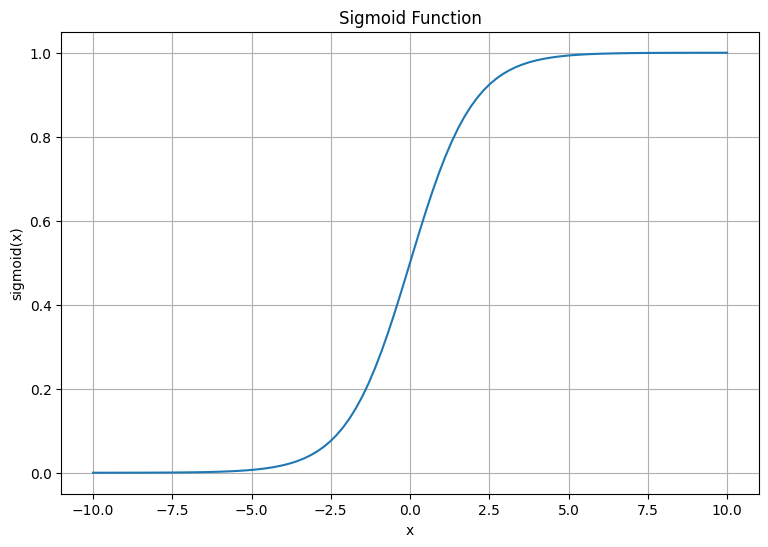

In [5]:
def sigmoid_general(x):
    return 1 / (1 + np.exp(-x))

# Generate a range of values from -10 to 10
x_s = np.linspace(-10, 10, 100)

# Apply the sigmoid function to these values
y_s = sigmoid_general(x_s)

# Create the plot
plt.figure(figsize=(9, 6))
plt.plot(x_s, y_s)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.show()

### Kostenfunktion L<sub>logit</sub>(D, f) <a name="L_logit"></a>

Die logistische Kostenfunktion **L<sub>logit</sub>** von **f** bzgl. **D** ist definiert durch
$$
L_{\text{logit}}(D, f) = -\sum_{i=1}^{m} y(i) \ln f(x(i)) + (1-y(i)) \ln(1- f(x(i)))
$$

Natürlich, ich kann das gerne erklären.

Die logistische Kostenfunktion, oft als **L<sub>logit<sub>** bezeichnet, ist ein zentraler Bestandteil der logistischen Regression. Sie misst, wie gut ein Modell, repräsentiert durch eine Funktion `f`, einen gegebenen Datensatz `D` vorhersagt.

Wie wir bereits wissen, nimmt die Funktion `f` einen Vektor aus **R<sup>n</sup>** (dem n-dimensionalen reellen Raum) und gibt einen Wert zwischen 0 und 1 aus. Die Kostenfunktion **L<sub>logit<sub>** summiert die Kosten aller Beispiele im Datensatz. Jedes Beispiel besteht aus einem Eingabevektor **x<sup>(i)</sup>** und einem zugehörigen Ausgabewert**y<sup>(i)</sup>**, der entweder 0 oder 1 ist.

Die Kosten eines einzelnen Beispiels hängen davon ab, wie gut die Vorhersage **f(y<sup>(i)</sup>)** mit der tatsächlichen Ausgabe **y<sup>(i)</sup>** übereinstimmt. Wenn **y<sup>(i)</sup> = 1** und **f(x<sup>(i)</sup>)** nahe bei 1 ist, dann ist der Kostenbeitrag dieses Beispiels nahe Null. Wenn jedoch **f(x<sup>(i)</sup>)** nahe bei 0 ist, dann ist der Kostenbeitrag dieses Beispiels hoch.

Umgekehrt, wenn **y<sup>(i)</sup> = 0** und **f(x<sup>(i)</sup>)** nahe bei 0 ist, dann ist der Kostenbeitrag dieses Beispiels nahe Null. Aber wenn **f(x<sup>(i)</sup>)** nahe bei 1 ist, dann ist der Kostenbeitrag dieses Beispiels hoch.

Das Ziel der logistischen Regression ist es, die Parameter `θ` der Funktion `f` so zu wählen, dass die gesamten Kosten minimiert werden. Dies wird oft als Optimierungsproblem formuliert, bei dem wir versuchen, `θ` zu finden, das **L<sub>logit</sub> (D, h<sup>θ</sup><sub>logit</sub>)** minimiert. Hierbei ist **h<sub>logit</sub>** die Hypothese, die wir anpassen möchten. d. h., wir suchen eine Lösung für das folgende Optimierungsproblem:
$$ min_θ L_{logit}(D,h^θ_{logit}) $$

Das Optimierungsproblem (1) ist **konvex**, d. h., es verfügt über einer eindeutige Lösung. Mithilfe numerischer Methoden wie Gradient Descent kann es auch effizient gelöst werden.

Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-5.559457366099212 + 0.7706702299147967 z))
wobei -5.559457366099212 der Achsenabschnitt und 0.7706702299147967 der Koeffizient ist.


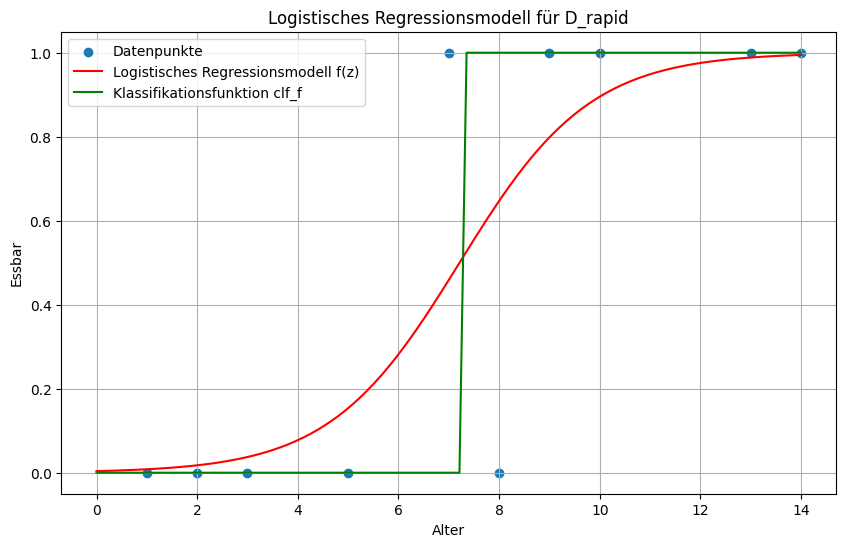

In [6]:
# Definieren Sie die Sigmoid-Funktion
def sigmoid_funktion(coef, intercept,z):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept[0])+" + "+str(coef[0][0])+" z))")
    print("wobei "+str(intercept[0])+" der Achsenabschnitt und "+str(coef[0][0])+" der Koeffizient ist.")
    return 1 / (1 + np.exp(-(intercept+coef*z)))


# Berechnen Sie die Sigmoid-Werte für die z-Werte
sigmoid_values = sigmoid_funktion(model.coef_, model.intercept_, xpts)

# Visualisieren Sie das Modell
plt.figure(figsize=(10, 6))
plt.scatter(D_rapid['age'], D_rapid['edible'], label='Datenpunkte')
plt.plot(xpts, sigmoid_values[0], color='red', label='Logistisches Regressionsmodell f(z)')
plt.plot(xpts, predictions, color='green', label='Klassifikationsfunktion clf_f')
plt.xlabel('Alter')
plt.ylabel('Essbar')
plt.title('Logistisches Regressionsmodell für D_rapid')
plt.legend()
plt.grid(True)
plt.show()

## 2.2.2. Evaluation <a name="evaluation"></a>

Einen Klassifikationsalgorithmus evaluiert man, ähnlich bei der Regression, nach den folgenden Schritten:
1. Datensatz **D** in einen Trainingsdatensatz **Dtrain** und einen Testdatensatz **Dtest** teilen.
2. Dtrain benutzen, <ins>um das Klassifikator zu Erlernen</ins>.
3. Dtest <ins>zur Evaluierung benutzen</ins>.
4. Wir benutzen **die Genauigkeit (engl. accuracy)** für den Klassifikator als Gütekriterium, anstelle des Bestimmtheitsmaßes wie bei der linearen Regression.

>*Wir betrachten hier nur den Fall der binären Klassifikation mit Klassen 0 und 1.*

>*Bei der Klassifikation ist eine Abstandsmessung deshalb nicht sinnvoll, weil die Vorhersagen diskrete Klassen sind, und nicht numerisch.*

Das 
Genauigkeitsmaß*** ac***c von*** ***c bzgl.*** ***D ist definiert durc $$\text{acc}(D, c) = \frac{1}{m} \sum_{i=1}^{m} \left(1 - |y^{(i)} - \text{clf}(x^{(i)})|\right)$$

in python wird das mit der Methode `metrics.accuracy_score(y, model.predict(x))` berechnet. Der Wert ***acc(D, c)*** ist also einfach das Verhältnis <ins>der korrekt klassifizierten Beispiele</ins> zu allen Beispielen.
>Accuracy is the <ins>ratio of **correct predictions** to the total number of predictions</ins>. It’s a good measure when the classes in your dataset are balanced.h

In [7]:
import sklearn.metrics as metrics

# Calculate the accuracy of the model
accuracy = metrics.accuracy_score(y, model.predict(x))
print("Accuracy: ", accuracy)

Accuracy:  0.8


$$\text{acc}(D_{rapid}, clf_f) = \frac{8}{10} = 0.8$$

**Das Problem -->** Die Genauigkeit ist nicht immer das beste Maß für die Leistung eines Klassifikators, insbesondere wenn die Klassen ungleich verteilt sind.

**Beispiel**:
Die Klassifikation eines Tumors als bösartig (Klasse 1) oder gutartig (Klasse 0).
- [Testdatensatz **<ins>Dtumor</ins>**](#beispiel1)
, der aus insgesamt 100 Beispielen besteht, wobei davon 99 Beispiele der Klasse 0 zugehörig sind und 1 Beispiel der Klasse 1 zugehörig ist.

So erreicht der triviale Klassifikator clf<sub>trivial</sub> definiert als **clf<sub>trivial</sub> = 0** (der also stets Gutartigkeit des Tumors vorhersagt, unabhängig von der tatsächlichen Beobachtung) eine Genauigkeit von **0.99**.

Deshalb, um eine bessere Einschätzung eines Klassifikators zu erhalten betrachtet man zusätzlich oft die sogenannte **Konfusionsmatrix (engl. confusion matrix)**.


Die Konfusionsmatrix ist ein nützliches Werkzeug, um die Leistung eines Klassifikators zu bewerten, da sie nicht nur die Gesamtgenauigkeit, sondern auch andere Metriken wie <ins>Sensitivität (auch als Recall oder True Positive Rate bekannt), Spezifität, Präzision und F1-Score</ins> berücksichtigt. Diese Metriken können ein vollständigeres Bild der Leistung eines Klassifikators liefern, insbesondere in Szenarien mit ungleicher Klassenverteilung. 

Die Konfusionsmatrix für ein binäres Klassifikationsproblem sieht folgendermaßen aus:

| | Vorhersage: Positiv clf=1 | Vorhersage: Negativ clf=0 |
|---|---|---|
| **Tatsächlich: Positiv** y=1 | True Positive TP(D,clf) | False Negative FN(D,clf) |
| **Tatsächlich: Negativ** y=0 | False Positive FP(D,clf) | True Negative TN(D,clf) |


wobei:
- True Positives (TP): $$TP(D, clf) = |\{i | y(i) = 1, clf(x(i)) = 1\}|$$
- True Negatives (TN): $$TN(D, clf) = |\{i | y(i) = 0, clf(x(i)) = 0\}|$$
- False Positives (FP): $$FP(D, clf) = |\{i | y(i) = 0, clf(x(i)) = 1\}|$$
- False Negatives (FN): $$FN(D, clf) = |\{i | y(i) = 1, clf(x(i)) = 0\}|$$

in python these values have th following order:
| |  |  |
|---|---|---|
|  | True Negatives **TN** | False Positives **FP** |
|  | False Negatives **FN** | True Positives **TP** |


Mit diesen Werten können wir dann verschiedene Metriken berechnen:

- **Genauigkeit**: $$\frac{TP + TN}{TP + TN + FP + FN}$$
- **Sensitivität (Recall)**: $$rec(D, clf)  = \frac{TP}{TP + FN}$$ `metrics.recall_score(y, model.predict(x))`: Recall (or sensitivity) is the <ins>ratio of **true positive** predictions to the total number of **actual positive** instances</ins>. It’s a good measure when the cost of a false negative is high.
- **Spezifität**: $$\frac{TN}{TN + FP}$$
- **Präzision**: $$prec(D, clf)  = \frac{TP}{TP + FP}$$ `metrics.precision_score(y, model.predict(x))`: Precision is the <ins>ratio of **true positive** predictions to the total number of **positive predictions**</ins>. It’s a good measure when the cost of a false positive is high. It is a useful measure when the cost of false positives is high.
- **F1-Score**: $$F1(D, clf)  = 2 \cdot \frac{Präzision \cdot Recall}{Präzision + Recall}$$
  Das F1-Maß ist das harmonische Mittel von Pra¨zision und Sensivita¨t und ist üblicherweise ein geeignetes Maß für die Gesamtqualität eines Klassifikators.
Um das weiter zu erklären sehen wir uns diesen Beispiel an:
>Let's say we have a model that is predicting whether an email is spam (positive class) or not spam (negative class). We have 100 emails, out of which 20 are actual spam emails and 80 are not spam.
>
>**Actual Positive**: These are the emails that are truly spam according to the ground truth. In our scenario, we have 20 actual positive instances (the 20 spam emails).
>
>**True Positive**: These are the spam emails that the model correctly identified as spam. Let's say our model correctly identified 15 out of the 20 actual spam emails. These 15 emails are the true positives.
>
>So, in this scenario, we have 20 actual positives and 15 true positives. The remaining 5 actual positives were missed by the model, these are known as false negatives. The model predicted them as not spam, but in reality, they were spam emails.
>
>Remember, a good model aims to maximize the number of true positives while minimizing the number of false negatives and false positives (emails that were not spam but were incorrectly identified as spam by the model). The metrics like precision and recall help us measure how well our model is doing in terms of these objectives.esondere in Fällen von ungleicher Klassenverteilung.

In [8]:
from sklearn.metrics import confusion_matrix

# Erstellen der Konfusionsmatrix
y_predictions = clf.predict(x)
cm = confusion_matrix(y, y_predictions)
# Ausgeben der Konfusionsmatrix
print(cm)

[[4 1]
 [1 4]]


In [9]:
'''Der zurückgegebene Wert ist ein Dezimalwert zwischen 0 und 1, wobei 1 eine perfekte Genauigkeit bedeutet (alle Vorhersagen waren korrekt) und 0 bedeutet, dass keine Vorhersagen korrekt waren.'''
y_pred = model.predict(x)
precision = metrics.precision_score(y, y_pred)
print("precision: ", precision)

recall = metrics.recall_score(y, y_pred)
print("recall: ", recall)

f1 = metrics.f1_score(y, y_pred)
print("F1_score: ", f1)

precision:  0.8
recall:  0.8
F1_score:  0.8000000000000002


## 2.2.3. Mehrklassenklassifizierung <a name="mehrklassenklassifizierung"></a>

Klassifikationsprobleme mit mehr als zwei Klassen, auch bekannt als **multiklassen Klassifikationsprobleme**, können in eine Reihe von binären Klassifikationsproblemen transformiert werden. Dieser Ansatz wird oft als **One-vs-All** oder **One-vs-Rest** bezeichnet.
**B Beispil:** 

1. Wir haben einen Datensatz `D_animals` mit Tieren, die wir in drei Klassen klassifizieren wollen: Hund (Klasse 0), Wolf (Klasse 1) und Dingo (Klasse 2). Die Merkmale, die wir zur Klassifikation verwenden, sind da*Alter*er (im Sinne von erreichtem Lebensalter des Tieres) und da*Gewicht*ht.

2. Wir visualisieren die Daten *2Dnale Projek*llt).

3. Wir trainieren se**parat drei logistische M**odelle f jeweiligenür die Klassen Hund, Wolf und Dingo. Das bedeutet, wir erstellen drei Versionen des Datensatzes `D_animals` mit binären Klassen, nämlich `D_Hund_animals`, `D_Wolf_animals` und `D_Dingo_animals`.

4. Für den Datensatz `D_Hund_animals` erhalten alle vorherigen Hund-Instanzen die Klasse 1 und alle übrigen Instanzen die Klasse 0. Ähnliche Transformationen werden für die Datensätze `D_Wolf_animals` und `D_Dingo_animals` durchgeführt.

5. Für diese drei Datensätze erhalten wir die folgenden logistischen Modelle:

    - Für Hunde: $$f_{Hund}(y,z) \approx \frac{1}{1+e^{-17.131+1.386y-0.0519z}}$$
    - Für Wölfe: $$f_{Wolf}(y,z) \approx \frac{1}{1+e^{20.99-0.928y-0.239z}}$$
    - Für Dingos: $$f_{Dingo}(y,z) \approx \frac{1}{1+e^{11.707-1.194y+0.304z}}$$

Diese Modelle können dann verwendet werden, um die Klassenzugehörigkeit neuer Instanzen zu bestimmen. Jedes Modell gibt die Wahrscheinlichkeit an, dass eine gegebene Instanz zu seiner jeweiligen Klasse gehört, und die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage ausgewählt.er sein.

   age  weight  type
0   12      12     0
1   13      34     0
2   16      30     1
3   14      15     2
4   15      39     1
5   15      13     2
6   10       5     0
7   17      56     1
8   14      11     2
9   11      23     0


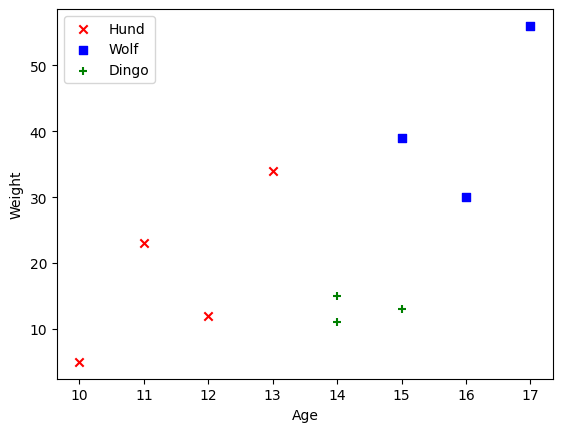

In [43]:
D_animals = pd.read_csv("./uebung_2_2/sl_logreg_ex_animals.csv")
print(D_animals)

X = D_animals.iloc[:, 0:-1].to_numpy()
x = X[:, 0]
y = X[:, 1]
z = D_animals.iloc[:, 2].to_numpy()

plt.scatter(D_animals[z==0]["age"], D_animals[z==0]["weight"], facecolor='red', marker='x', label = 'Hund')
plt.scatter(D_animals[z==1]["age"], D_animals[z==1]["weight"], facecolor='blue', marker='s', label = 'Wolf')
plt.scatter(D_animals[z==2]["age"], D_animals[z==2]["weight"], facecolor='green', marker='+', label = 'Dingo')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [44]:
# Definieren Sie die Sigmoid-Funktion
def sigmoid_funktion(coef, intercept, z1, z2):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept[0])+" + "+str(coef[0][0])+" z1 + "+str(coef[0][1])+" z2))")    
    return (intercept[0], coef[0][0], coef[0][1], 1 / (1 + np.exp(-intercept - coef[0][0]*z1 - coef[0][1]*z2)))

def sigmoid_funktion_berechnen(intercept, coef1, coef2, z1, z2):
    result = 1 / (1 + np.exp(-intercept - coef1*z1 - coef2*z2))
    return result

In [45]:
# 3. Trainieren Sie separate logistische Modelle für jede Klasse
models = []
classificator = []
y_predictions = []

animal_types = pd.unique(D_animals['type'])

for animal_type in animal_types:
    # Erstellen Sie binäre Klassen
    z = np.where(D_animals['type'] == animal_type, 1, 0)
    # Trainieren Sie das Modell
    clf = LogisticRegression()
    clf.fit(X, z)
    y_pred = clf.predict(X)
    classificator.append(sigmoid_funktion(clf.coef_, clf.intercept_, x,y_pred))
    models.append((clf, z, y_pred))

print("--------------------------------------------")
print(models)
print("--------------------------------------------")
print(classificator)
#y_predictions

Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(17.13078780852264 + -1.3855814445577417 z1 + 0.05187540790551659 z2))
Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-20.989576675558403 + 0.9280309675625009 z1 + 0.23942666630515022 z2))
Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-11.706973992934048 + 1.194054083636872 z1 + -0.30379738685191543 z2))
--------------------------------------------
[(LogisticRegression(), array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1]), array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])), (LogisticRegression(), array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0]), array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0])), (LogisticRegression(), array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0]), array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0]))]
--------------------------------------------
[(17.13078780852264, -1.3855814445577417, 0.05187540790551659, array([0.63545375, 0.30366715, 0.0064416 , 0.09386315, 0.02526036,
       0.02526036, 0.96533848, 0.

Wir klassifizieren ein neues Beispiel **x = (12, 40)** unter Verwendung unserer Klassifikatoren **f<sub>Hund</sub>** , **f<sub>Wolf</sub>** und **f<sub>Dingo</sub>**. Jeder dieser Klassifikatoren gibt eine Wahrscheinlichkeit aus, dass x zu einer bestimmten Klasse gehört. Das Beispiel x wird dann der Klasse ci zugewiesen, für die **f<sub>i</sub>(x) <ins>maximal</ins>** ist.

In [46]:
def classify(classificator, x):
    dicionary = {
    'Hund': sigmoid_funktion_berechnen(classificator[0][0], classificator[0][1], classificator[0][2], x[0], x[1]),
    'Wolf': sigmoid_funktion_berechnen(classificator[1][0], classificator[1][1], classificator[1][2], x[0], x[1]),
    'Dingo': sigmoid_funktion_berechnen(classificator[2][0], classificator[2][1], classificator[2][2], x[0], x[1])
    }
    return dicionary
    

animal_dicionary = classify(classificator, (12, 40))
max(animal_dicionary, key=animal_dicionary.get)

'Hund'

So errechnen wir:

$$f_{\text{Hund}}(12,40) \approx \frac{1}{1+e^{-17.131+1.386 \cdot 12-0.0519 \cdot 40}} \approx 0.929$$

$$f_{\text{Wolf}}(12,40) \approx \frac{1}{1+e^{20.99-0.928 \cdot 12-0.239 \cdot 40}} \approx 0.427$$

$$f_{\text{Dingo}}(12,40) \approx \frac{1}{1+e^{11.707-1.194 \cdot 12+0.304 \cdot 40}} \approx 0$$

Und es ergibt sich:

$$clf_{f_{\text{Hund}}, f_{\text{Wolf}}, f_{\text{Dingo}}}(x) = \text{Hund}$$

Jetzt können wir die Funktionen wie folgt visualiesieren:

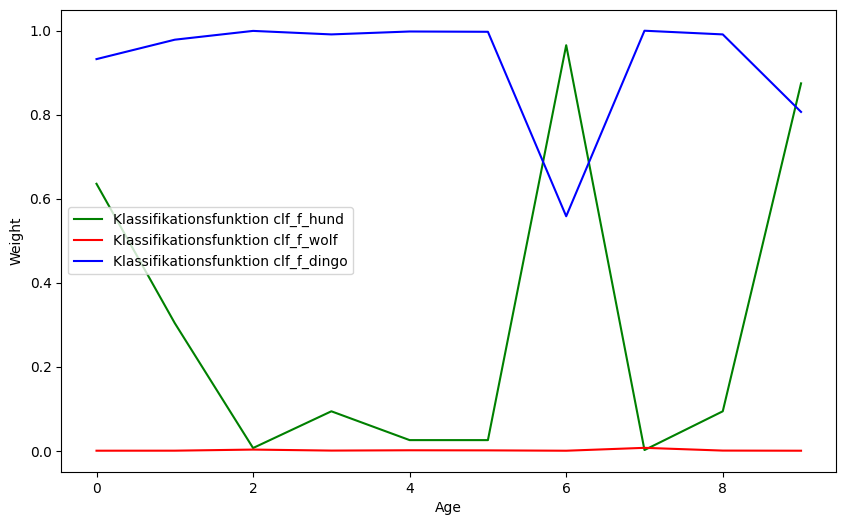

In [47]:
z = D_animals.iloc[:, 2].values
f_hund = classificator[0][3]
f_wolf = classificator[1][3]
f_dingo = classificator[2][3]


plt.figure(figsize=(10, 6))
'''
plt.scatter(D_animals[z==0]["age"], D_animals[z==0]["weight"], facecolor='red', marker='x', label = 'Hund')
plt.scatter(D_animals[z==1]["age"], D_animals[z==1]["weight"], facecolor='blue', marker='s', label = 'Wolf')
plt.scatter(D_animals[z==2]["age"], D_animals[z==2]["weight"], facecolor='green', marker='+', label = 'Dingo')
'''
plt.plot(np.arange(len(f_hund)), f_hund, color='green', label='Klassifikationsfunktion clf_f_hund')
plt.plot(np.arange(len(f_wolf)), f_wolf, color='r', label='Klassifikationsfunktion clf_f_wolf')
plt.plot(np.arange(len(f_dingo)), f_dingo, color='b', label='Klassifikationsfunktion clf_f_dingo')
'''
plt.plot(xpts, f_hund_ypts, color='green', label='Klassifikationsfunktion clf_f')
plt.plot(xpts, f_wolf_ypts, color='r', label='Klassifikationsfunktion clf_f')
plt.plot(xpts, f_dingo_ypts, color='b', label='Klassifikationsfunktion clf_f')
'''

plt.xlabel('Age')
plt.ylabel('Weight')
plt.legend()
plt.show()

- Zur **Evaluation von Modellen** zur Klassifikation mit mehreren Klassen nutzen w auch hierir die Metriken **Genauigkeit**, **Präzision**, **Sensitivität** und **F1**.**Aber**
b- Bei mehr als zwei Klassen gibt es keine eindeutige "positive" und keine eindeutige "negative" Klas 
- Man benutzt hier üblicherweise **klassenspezifische Varianten** von Präzision, Sensitivität und F1Daher --> b
- Bei **k Klassen** bekomme also jeweils **k verschiedene Werte** für Präzis  ion, Sensitivität und F1.
- Für eine Klasse c schreiben wir dann **precc**, **recc** und **F1c** für die entsprechende klassenspezifische Vari werden.e.

In [48]:
import sklearn.metrics as metrics
#models = (clf, z, y_pred)

f_dict = {
    0: 'Hund',
    1: 'Wolf',
    2: 'Dingo'
}
i=0
for model in models:
    print('Metrics of f_'+f_dict.get(i))
    print("Accuracy: ", metrics.accuracy_score(model[1], model[2]))
    print("precision: ", metrics.precision_score(model[1], model[2]))
    print("recall: ", metrics.recall_score(model[1], model[2]))
    print("F1_score: ", metrics.f1_score(model[1], model[2]))
    print('And the Confusion matrix is ')
    print(confusion_matrix(model[1], model[2]))
    i+=1


Metrics of f_Hund
Accuracy:  1.0
precision:  1.0
recall:  1.0
F1_score:  1.0
And the Confusion matrix is 
[[6 0]
 [0 4]]
Metrics of f_Wolf
Accuracy:  1.0
precision:  1.0
recall:  1.0
F1_score:  1.0
And the Confusion matrix is 
[[7 0]
 [0 3]]
Metrics of f_Dingo
Accuracy:  1.0
precision:  1.0
recall:  1.0
F1_score:  1.0
And the Confusion matrix is 
[[7 0]
 [0 3]]


**Zusammenfassung: simplere Lösung**

Wir haben hier ein Multiklassen Problem <ins>mit mehr als zwei Klassen</ins>, deshalb erstellt `multi_class='ovr'` für jede Klasse eine separate binäre Klassifikation. In diesem Fall könnten wir auf die Koeffizienten jeder einzelnen “Funktion” oder Entscheidungsgrenze mit `clf.coef_[i]` und `clf.intercept_[i]` zugreifen, wobei i der Index der Klasse ist.

[[-1.38558144  0.05187541]
 [ 0.92803097  0.23942667]
 [ 1.19405408 -0.30379739]]
[ 17.13078781 -20.98957668 -11.70697399]


<Figure size 640x480 with 0 Axes>

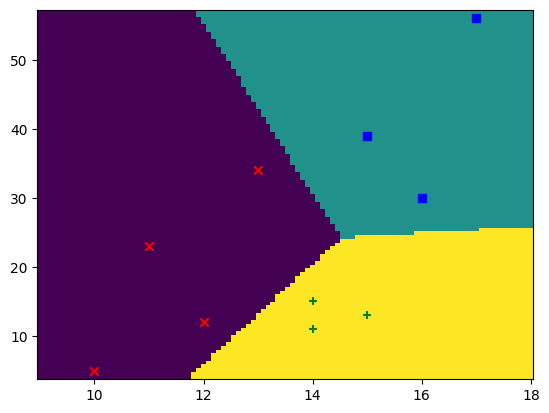

In [97]:
from sklearn.inspection import DecisionBoundaryDisplay

X = D_animals.iloc[:, 0:-1].to_numpy()
z = D_animals.iloc[:, 2].to_numpy()

#this line is creating a logistic regression model, training it on your data, and then storing the trained model in the variable clf.
#For that the model will use a strategy known as “one-vs-rest” (OvR) for multi-class classification
clf = LogisticRegression(multi_class='ovr').fit(X,z)

print(clf.coef_)
print(clf.intercept_)

plt.figure()

#It generates a plot object that represents the decision boundaries of an estimator (in your case, clf which is a logistic regression model)
DecisionBoundaryDisplay.from_estimator(clf,X,plot_method="pcolormesh")

plt.scatter(D_animals[z==0]["age"], D_animals[z==0]["weight"], facecolor='red', marker='x', label = 'Hund')
plt.scatter(D_animals[z==1]["age"], D_animals[z==1]["weight"], facecolor='blue', marker='s', label = 'Wolf')
plt.scatter(D_animals[z==2]["age"], D_animals[z==2]["weight"], facecolor='green', marker='+', label = 'Dingo')


plt.show()

In [50]:
clf.classes_

array([0, 1, 2], dtype=int64)

In [54]:
clf.predict(X)

array([0, 0, 1, 2, 1, 2, 0, 1, 2, 0], dtype=int64)

## 2.2.4. Nicht-lineare Modelle <a name="nl_modelle"></a>
**Hier ist ein Beispiel für ein nicht-lineares Modell:**
1. In einer Produktionsstätte für Schrauben soll die Qualitätssicherung erhöht werden.
2. Ein Modell soll erlernt werden, das automatisch Schrauben außerhalb der Norm aussortiert.
3. Die Merkmale, die für das Modell verwendet werden, sind die Länge und das Gewicht der Schraube.
4. Die Klassen sind 1 (Qualität ausreichend) und 0 (Qualität nicht ausreichend).
5. Ein beispielhafter Datensatz `D_screws` ist gegeben, der die Merkmale und Klassen für verschiedene Schrauben enthält.
6. Ein optimales logistisches Modell `f_screws` wird trainiert, um die Klassifikationsgrenze zu bestimmen.
7. Das Modell `f_screws` repräsentiert die Daten jedoch nicht adäquat und klassifiziert insbesondere alle Daten aus `fscrews` als "nicht ok".

In diesem Fall, da wir ein binäres Klassifikationsproblem haben (mit den Klassen 0 und 1), erstellt das Modell mit multi_class='ovr' tatsächlich nur eine einzige “Funktion” oder Entscheidungsgrenze. Diese trennt die Klasse 1 von der Klasse 0. Die Koeffizienten dieser Funktion können wir mit clf.coef_ und den Achsenabschnitt mit clf.intercept_ abrufen. Diese repräsentieren die Gewichte und den Bias der logistischen Funktion, die zur Klassifikation verwendet wird.

### Erster Ansatz:

[[-0.000674   -0.16943785]]
[4.37534475]
accuracy:  0.6
precision:  0.0
recall:  0.0
F1_score:  0.0


<Figure size 640x480 with 0 Axes>

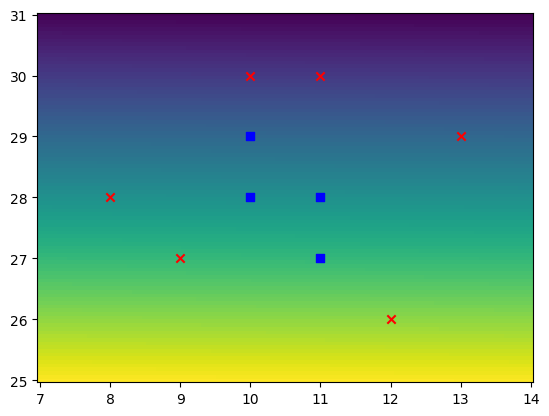

In [132]:
# Erstellen Sie den Datensatz
D_screws = pd.DataFrame({
    'Gewicht': [11, 10, 13, 11, 11, 12, 10, 10, 9, 8],
    'Laenge': [27, 28, 29, 28, 30, 26, 29, 30, 27, 28],
    'Ok': [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
})

# Teilen Sie die Daten in Merkmale und Ziel auf
X = D_screws[['Gewicht', 'Laenge']].to_numpy()
x1 = X[:, 0]
x2 = X[:, 1]
y = D_screws['Ok']

# Trainieren Sie das Modell
clf = LogisticRegression(multi_class='ovr')
clf.fit(X, y)

# Machen Sie Vorhersagen
y_pred = clf.predict(X)

print("accuracy: ", accuracy_score(y, y_pred))
print("precision: ", precision_score(y, y_pred, zero_division=0))
print("recall: ", recall_score(y, y_pred, zero_division=0))
print("F1_score: ", f1_score(y, y_pred, zero_division=0))

plt.figure()

#It generates a plot object that represents the decision boundaries of an estimator (in your case, clf which is a logistic regression model)
DecisionBoundaryDisplay.from_estimator(clf,X,plot_method="pcolormesh")

plt.scatter(D_screws[y==0]["Gewicht"], D_screws[y==0]["Laenge"], facecolor='red', marker='x', label = 'OK')
plt.scatter(D_screws[y==1]["Gewicht"], D_screws[y==1]["Laenge"], facecolor='blue', marker='s', label = 'Nicht OK')


plt.show()

In [137]:
def logistische_funktion(coef, intercept, z1, z2):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept)+" + "+str(coef[0])+" z1 + "+str(coef[1])+" z2))")
    return 1 / (1 + np.exp(-intercept - coef[0]*z1 - coef[1]*z2))


# Berechnen Sie die Sigmoid-Werte für die z-Werte
y_pred_class0 = logistische_funktion(clf.coef_[0], clf.intercept_, x1, x2)
print(y_pred_class0)

y_pred_class1 = 1 - y_pred_class0
print(y_pred_class1)


Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-([4.37534475] + -0.0006739962293646284 z1 + -0.16943784567512482 z2))
[0.44846095 0.40717531 0.36653407 0.40701263 0.32844984 0.49046936
 0.36700368 0.32859852 0.44879439 0.40750073]
[0.55153905 0.59282469 0.63346593 0.59298737 0.67155016 0.50953064
 0.63299632 0.67140148 0.55120561 0.59249927]


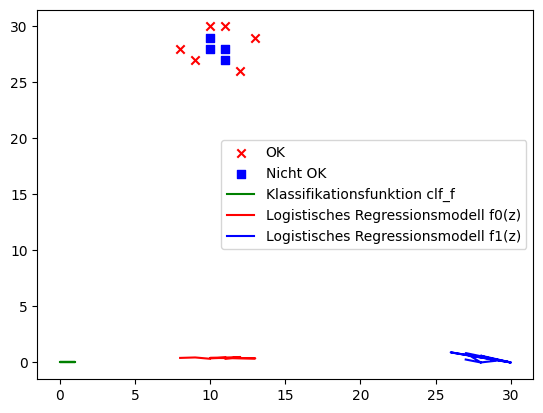

In [143]:
# Erstellen Sie eine neue Figur
plt.figure()


plt.scatter(D_screws[y==0]["Gewicht"], D_screws[y==0]["Laenge"], facecolor='red', marker='x', label = 'OK')
plt.scatter(D_screws[y==1]["Gewicht"], D_screws[y==1]["Laenge"], facecolor='blue', marker='s', label = 'Nicht OK')
plt.plot(y, y_pred, color='green', label='Klassifikationsfunktion clf_f')
plt.plot(x1, y_pred_class0, color='r', label='Logistisches Regressionsmodell f0(z)')
plt.plot(x2, y_pred_class2, color='b', label='Logistisches Regressionsmodell f1(z)')

# Fügen Sie Achsentitel und Legende hinzu
plt.legend()

# Zeigen Sie die Abbildung an
plt.show()

### Korrigierter Ansatz:
Wenn die Beziehung zwischen den Merkmalen und der Zielvariable nichtlinear ist, können Sie neue Merkmale erstellen, die diese Nichtlinearität erfassen. Zum Beispiel könnten Sie quadratische oder kubische Terme hinzufügen, oder Sie könnten Interaktionsterme zwischen Merkmalen hinzufügen.

Coefficients:  [[ 0.04787326  0.04879406 -0.87428798  0.66532519 -0.1378528 ]]
Intercept:  [8.12052784]
[1 1 0 1 0 0 0 0 1 0]
Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-([8.12052784] + 0.04787326035288631 z1 + 0.04879406433286594 z2 0.04879406433286594 z3 0.04879406433286594 z4 0.04879406433286594 z5))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
accuracy for class 1:  0.8
precision for class 1:  0.75
recall for class 1:  0.75
F1_score for class 1:  0.75


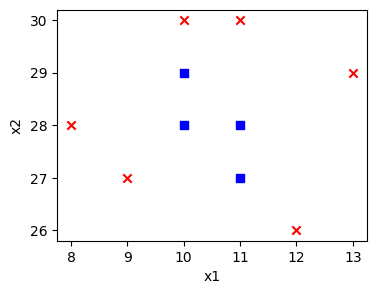

In [48]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Your DataFrame
D_screws_extended = pd.DataFrame({
    'Gewicht': [11, 10, 13, 11, 11, 12, 10, 10, 9, 8],
    'Laenge': [27, 28, 29, 28, 30, 26, 29, 30, 27, 28],
    'x1^2': [121, 100, 169, 121, 121, 144, 100, 100, 81, 64],
    'x1x2': [297, 280, 377, 308, 330, 312, 290, 300, 243, 224],
    'x2^2': [729, 784, 841, 784, 900, 676, 841, 900, 729, 784],
    'Ok': [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
})

# Define your features and target variable
X = D_screws_extended.drop('Ok', axis=1).to_numpy()  # Selecting only 'x1' and 'x2' for visualization
x1 = D_screws_extended['Gewicht'].to_numpy()
x2 = D_screws_extended['Laenge'].to_numpy()
x3 = D_screws_extended['x1^2'].to_numpy()
x4 = D_screws_extended['x1x2'].to_numpy()
x5 = D_screws_extended['x2^2'].to_numpy()
y = D_screws_extended['Ok'].to_numpy()

# Create and fit your model
clf = LogisticRegression(multi_class='ovr').fit(X, y)

# Print the coefficients and intercept of the model
print("Coefficients: ", clf.coef_)
print("Intercept: ", clf.intercept_)


y_pred = clf.predict(X)
print(y_pred)

def logistische_funktion(coef, intercept, z1, z2, z3, z4, z5):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept)+" + "+str(coef[0])+" z1 + "+str(coef[1])+" z2 "+str(coef[1])+" z3 "+str(coef[1])+" z4 "+str(coef[1])+" z5))")
    return 1 / (1 + np.exp(-intercept - coef[0]*z1 - coef[1]*z2 - coef[1]*z3 - coef[1]*z4 - coef[1]*z5))


# Berechnen Sie die Sigmoid-Werte für die z-Werte
clf_f_class0 = logistische_funktion(clf.coef_[0], clf.intercept_, x1, x2, x3, x4, x5)
print(clf_f_class0)

clf_f_class1 = 1 - clf_f_class0
print(clf_f_class1) 


print("accuracy for class 1: ", accuracy_score(y, y_pred))
print("precision for class 1: ", precision_score(y, y_pred, zero_division=0))
print("recall for class 1: ", recall_score(y, y_pred, zero_division=0))
print("F1_score for class 1: ", f1_score(y, y_pred, zero_division=0))

plt.figure(1, figsize=(4, 3))
# Also plot the training points
#plt.scatter(x1, x2, c=y, cmap=plt.cm.Paired)

plt.scatter(D_screws_extended[y==0]["Gewicht"], D_screws_extended[y==0]["Laenge"], facecolor='red', marker='x', label = 'OK')
plt.scatter(D_screws_extended[y==1]["Gewicht"], D_screws_extended[y==1]["Laenge"], facecolor='blue', marker='s', label = 'Nicht OK')

plt.xlabel('x1')
plt.ylabel('x2')

plt.show()


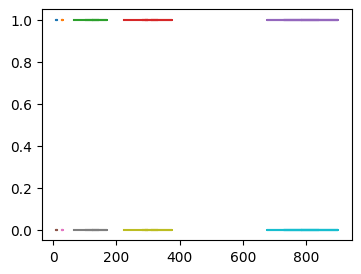

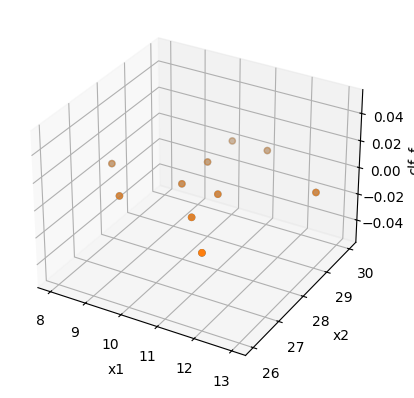

In [41]:

plt.figure(1, figsize=(4, 3))
# Also plot the training points
plt.plot(x1, clf_f_class0)
plt.plot(x2, clf_f_class0)
plt.plot(x3, clf_f_class0)
plt.plot(x4, clf_f_class0)
plt.plot(x5, clf_f_class0)

plt.plot(x1, clf_f_class1)
plt.plot(x2, clf_f_class1)
plt.plot(x3, clf_f_class1)
plt.plot(x4, clf_f_class1)
plt.plot(x5, clf_f_class1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Choose two features to plot against (e.g., 'x1' and 'x2')
ax.scatter(x1, x2, clf_f_class1)
ax.scatter(x1, x2, clf_f_class1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('clf_f')
plt.show()


## 2.2.5. Andere Beispiele <a name="beispiele"></a>

### Beipiel 1: D<sub>tumor</sub> <a name="beispiel1"></a>

Man hat beispielsweise einen Testdatensatz **D<sub>tumor</sub>**, der aus insgesamt 100 Beispielen besteht, wobei davon 99 Beispiele der Klasse 0 zugehörig sind
und <ins>1 Beispiel</ins> der <ins>Klasse 1</ins> zugehörig ist. 

In [16]:
# Erstellen Sie eine Liste mit 99 Nullen und 1 Eins
data = {
    'person': list(range(1, 101)),
    'Klasse': [0]*99 + [1]
}

# Erstellen Sie einen DataFrame mit der Liste
D_tumor = pd.DataFrame(data)
D_tumor

,person,Klasse
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
95,96,0
96,97,0
97,98,0
98,99,0


Die Genauigkeit des Modells ist 0.99
Die Präzesion des Modells ist 1.0
Die Recall des Modells ist 0.0
Die F1_score des Modells ist 0.0
Die Konfusionsmatrix ist:
[[99  0]
 [ 1  0]]


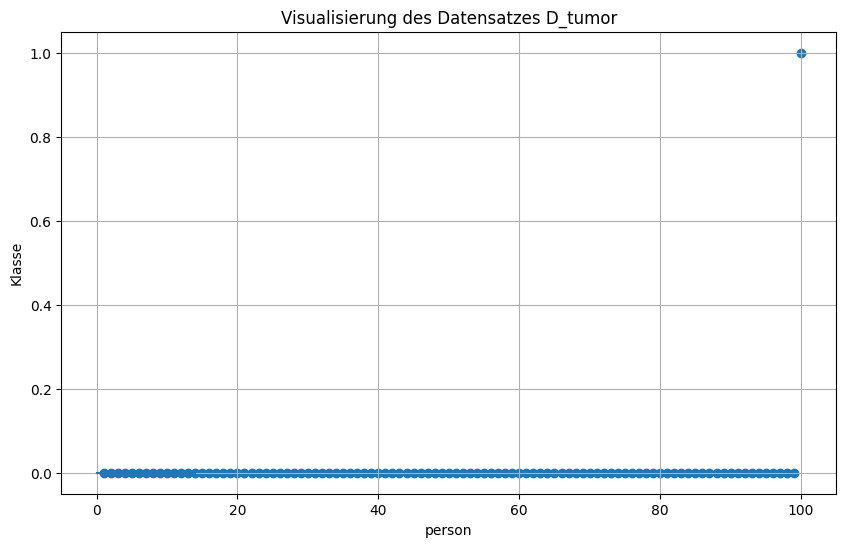

In [17]:
from sklearn.linear_model import LogisticRegression
x = D_tumor["person"].to_numpy().reshape(-1, 1)
y = D_tumor["Klasse"].to_numpy()

clf = LogisticRegression()
model = clf.fit(x,y)

xpts = np.linspace(0, 14, 100)



# Trainieren Sie das Modell
clf = LogisticRegression()
model = clf.fit(x, y)

# Vorhersagen auf den Trainingsdaten
y_pred = model.predict(x)

# Berechnen Sie die Metriken
#Precisiom hier is the result of 0/0 which is actually undefined.
#this is a special case. We replace the value with 1 instead.
precision = precision_score(y, y_pred, zero_division=1)
recall = recall_score(y, y_pred, zero_division=1)
f1 = f1_score(y, y_pred, zero_division=1)
accuracy = accuracy_score(y, y_pred)

print(f"Die Genauigkeit des Modells ist {accuracy}")
print(f"Die Präzesion des Modells ist {precision}")
print(f"Die Recall des Modells ist {recall}")
print(f"Die F1_score des Modells ist {f1}")


# Berechnen Sie die Konfusionsmatrix
cm = confusion_matrix(y, y_pred)

print(f"Die Konfusionsmatrix ist:\n{cm}")

plt.figure(figsize=(10, 6))
plt.scatter(D_tumor['person'], D_tumor['Klasse'])
plt.plot(xpts, y_pred)
plt.title('Visualisierung des Datensatzes D_tumor')
plt.xlabel('person')
plt.ylabel('Klasse')
plt.grid(True)
plt.show()

so erreicht der triviale Klassifikator **clf<sub>trivial</sub>** definiert als **clf<sub>trivial</sub> = 0** (der also stets Gutartigkeit des Tumors vorhersagt, unabhängig von der tatsächlichen Beobachtung) eine Genauigkeit von **0.99**. Um eine bessere Einschätzung eines Klassifikators zu erhalten betrachtet man zusätzlich oft die sogenannte Konfusionsmatrix (engl. confusion matrix).

## 2.2.6. Zusammenfassung <a name="zusammenfassung"></a>

Um einen logistischen Regressionsmodell zu kalkulieren, folgen wir die folgenden Schritte:



### Für einen 2D-Modell:  <a name="2d"></a>
1. **Daten vorbereiten**: Der erste Schritt besteht darin, Ihre Daten für das Modell vorzubereiten. Dies kann das Laden der Daten, das Aufteilen in Trainings- und Testsets, das Skalieren der Daten und das Behandeln von fehlenden Werten umfassen.

In [137]:
# Create a pandas DataFrame
D_rapid = pd.read_csv("./uebung_2_2/sl_logreg_ex_rapid.csv")
print(D_rapid)
x = D_rapid["age"].to_numpy().reshape(-1, 1)
print(x)
y = D_rapid["edible"].to_numpy()

   age  edible
0    5       0
1   14       1
2   10       1
3    7       1
4    2       0
5    1       0
6    9       1
7    8       0
8    3       0
9   13       1
[[ 5]
 [14]
 [10]
 [ 7]
 [ 2]
 [ 1]
 [ 9]
 [ 8]
 [ 3]
 [13]]


2. **Modell erstellen**: Erstellen Sie ein Instanz des `LogisticRegression` Modells aus der `sklearn.linear_model` Bibliothek.

In [138]:
clf = LogisticRegression()

3. **Modell trainieren**: Verwenden Sie die `fit` Methode des Modells, um es auf Ihren Trainingsdaten zu trainieren. Sie müssen die Merkmale (Eingaben) und die Zielvariable (Ausgabe) als Argumente übergeben.

In [139]:
clf.fit(x,y)

LogisticRegression()

4. **Vorhersagen treffen**: Nachdem das Modell trainiert wurde, können wir die `predict` Methode verwenden, um Vorhersagen auf neuen Daten zu treffen. Die erhaltene Funktion nennen wir die Klassifikationsfunktion $$clf_f$$
Wir können auch die  `predict_proba` Methode verwenden, um die Wahrscheinlichkeiten für jede Klasse zu erhalten.

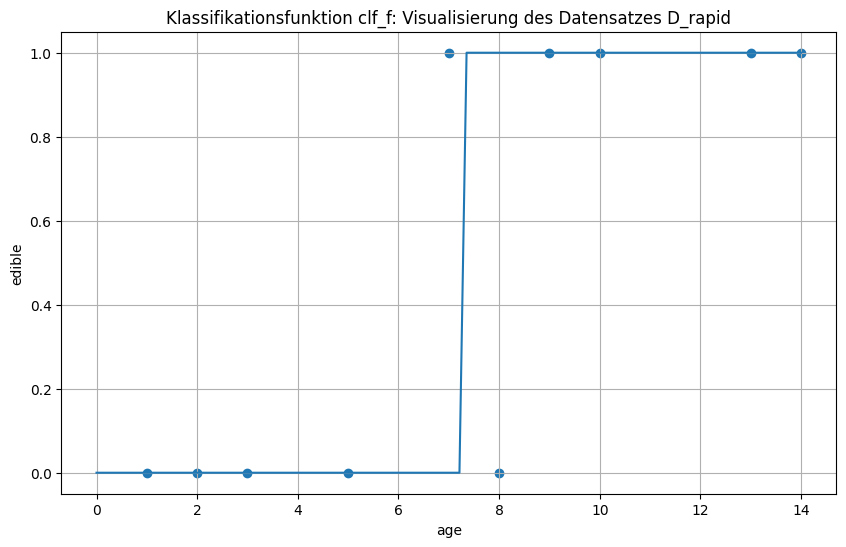

In [140]:
xpts = np.linspace(0, 14, 100)

y_pred = clf.predict(x)
y_pred_xpts = clf.predict(xpts.reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.scatter(D_rapid['age'], D_rapid['edible'])
plt.plot(xpts, y_pred_xpts)
plt.title('Klassifikationsfunktion clf_f: Visualisierung des Datensatzes D_rapid')
plt.xlabel('age')
plt.ylabel('edible')
plt.grid(True)
plt.show()

5. **Modell bewerten/evalueieren**: Verwenden Sie geeignete Metriken (wie Genauigkeit, Präzision, Recall usw.) um die Leistung Ihres Modells zu bewerten. In `sklearn` können Sie Funktionen wie `accuracy_score`, `precision_score`, `recall_score` usw. aus dem `sklearn.metrics` Modul verwenden.
Wir können auch die Konfusionsmatrix von <ins>clf</ins> bzgl. <ins>D</ins> berechnen.

In [141]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y, y_pred)
print("Accuracy: ", accuracy)

precision = metrics.precision_score(y, y_pred)
print("precision: ", precision)

recall = metrics.recall_score(y, y_pred)
print("recall: ", recall)

f1 = metrics.f1_score(y, y_pred)
print("F1_score: ", f1)

cm = confusion_matrix(y, y_pred)
# Ausgeben der Konfusionsmatrix
print(cm)

Accuracy:  0.8
precision:  0.8
recall:  0.8
F1_score:  0.8000000000000002
[[4 1]
 [1 4]]


6. **Das optimale logistische Modell f(z) berechnen**: wir verwenden `model.coef_` oder `model.intercept_`, um die Sigmoid-Funktion zu berechnen. Wir erhalten eine Optimal-angepasstes logistisches Modell im Form von: $$ f(z) = \frac{1}{1+e^{-(\theta_0+\theta_1x_1+...+\theta_nx_n)}}$$

In [142]:
# Definieren Sie die Sigmoid-Funktion
def sigmoid_funktion(coef, intercept,z):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept[0])+" + "+str(coef[0][0])+" z))")
    print("wobei "+str(intercept[0])+" der Achsenabschnitt und "+str(coef[0][0])+" der Koeffizient ist.")
    return 1 / (1 + np.exp(-(intercept+coef*z)))


# Berechnen Sie die Sigmoid-Werte für die z-Werte
sigmoid_values = sigmoid_funktion(clf.coef_, clf.intercept_, xpts)
sigmoid_values

Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-5.559457366099212 + 0.7706702299147967 z))
wobei -5.559457366099212 der Achsenabschnitt und 0.7706702299147967 der Koeffizient ist.


array([[0.00383609, 0.00427591, 0.00476591, 0.00531176, 0.00591976,
        0.00659688, 0.00735089, 0.00819037, 0.00912484, 0.01016483,
        0.011322  , 0.01260923, 0.01404072, 0.01563215, 0.01740078,
        0.01936558, 0.02154737, 0.02396895, 0.02665527, 0.02963352,
        0.03293327, 0.03658661, 0.04062819, 0.04509532, 0.05002802,
        0.05546892, 0.06146328, 0.06805876, 0.07530519, 0.08325425,
        0.09195895, 0.10147303, 0.1118502 , 0.12314315, 0.13540246,
        0.14867529, 0.1630039 , 0.17842401, 0.19496308, 0.21263844,
        0.23145554, 0.25140613, 0.27246672, 0.29459728, 0.31774031,
        0.34182043, 0.36674449, 0.39240241, 0.41866861, 0.44540415,
        0.47245942, 0.49967744, 0.52689736, 0.55395833, 0.5807032 ,
        0.60698217, 0.632656  , 0.65759878, 0.68170002, 0.70486618,
        0.72702145, 0.74810791, 0.76808511, 0.7869292 , 0.80463159,
        0.8211974 , 0.83664373, 0.8509978 , 0.86429516, 0.87657794,
        0.8878932 , 0.89829144, 0.90782534, 0.91

7. **f(z) und clf<sub>f</sub> visualisieren**:

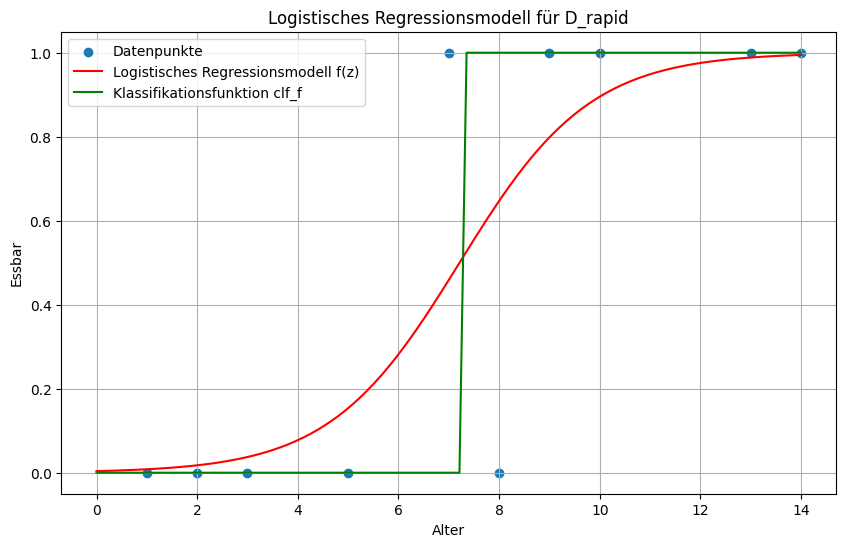

In [146]:
# Visualisieren Sie das Modell
plt.figure(figsize=(10, 6))
plt.scatter(D_rapid['age'], D_rapid['edible'], label='Datenpunkte')
plt.plot(xpts, sigmoid_values[0], color='red', label='Logistisches Regressionsmodell f(z)')
plt.plot(xpts, y_pred_xpts, color='green', label='Klassifikationsfunktion clf_f')
plt.xlabel('Alter')
plt.ylabel('Essbar')
plt.title('Logistisches Regressionsmodell für D_rapid')
plt.legend()
plt.grid(True)
plt.show()

### Für einen 3D-Modell: <a name="3d"></a>
Für ein 3D-Modell werden die Schritte wie folgt gefolgt:

   Flaeche  Entfernung  OK
0       40           4   1
1       30           3   1
2       45           8   0
3       35           6   0
4       20           4   0
5       50           7   1
6       30           4   0
7       45           4   1
8       40           5   0
9       25           1   1


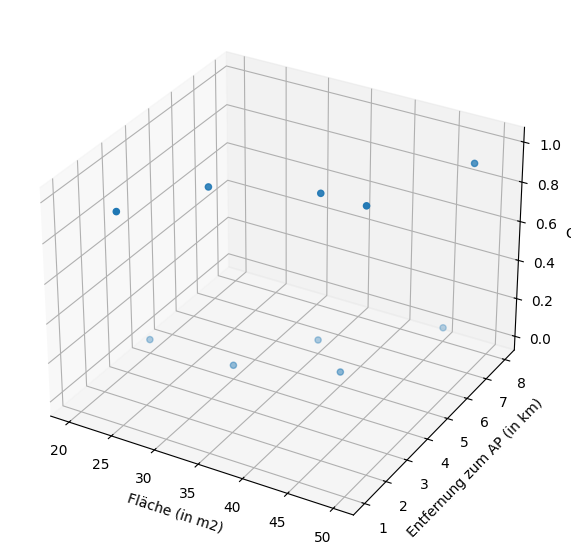

In [51]:
from mpl_toolkits.mplot3d import Axes3D

data = {
    'Flaeche': [40, 30, 45, 35, 20, 50, 30, 45, 40, 25],
    'Entfernung': [4, 3, 8, 6, 4, 7, 4, 4, 5, 1],
    'OK': [1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
}

D_apartment= pd.DataFrame(data)
print(D_apartment)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X = D_apartment[['Flaeche', 'Entfernung']].to_numpy()
x = X[:, 0]
y = X[:, 1]
z = D_apartment['OK'].to_numpy()

ax.scatter(x, y, z)
ax.set_xlabel('Fläche (in m2)')
ax.set_ylabel('Entfernung zum AP (in km)')
ax.set_zlabel('OK')
plt.show()

[1 1 0 0 0 1 0 1 1 1]


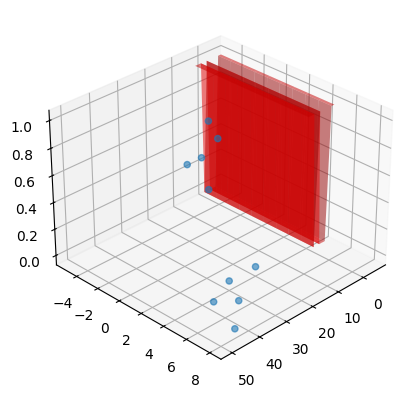

In [26]:
clf = LogisticRegression()
clf.fit(X,z)

# Predictions
predictions = clf.predict(X)
print(predictions)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a grid of x and y values
xpred, ypred = np.meshgrid(np.linspace(-5, 5, len(predictions)),
                   np.linspace(-5, 5, len(predictions)))

# Use your data for the z values
zpred = np.full(xpred.shape, predictions)

# Plot the surface
#scatter values
ax.scatter(x, y, z, label='Actual', alpha=0.6)

# Plot the function
ax.plot_surface(xpred, ypred, zpred, color="r", alpha = 0.5)

#ax.plot_surface(xpred, ypred, zpred, color = 'b', alpha = 0.3)
#a#x.scatter(x, y, predictions, color='green', label='Klassifikationsfunktion clf_f', marker='*')
ax.view_init(elev=30, azim=45)

plt.show()

In [27]:
cm = confusion_matrix(z, clf.predict(X))

# Ausgeben der Konfusionsmatrix
print("Konfusionsmatrix:")
print(cm)

Konfusionsmatrix:
[[4 1]
 [0 5]]


$$\text{acc}(D_{apartment}, clf_f) = \frac{8}{10} = 0.9$$

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(z, predictions)
precision = precision_score(z, predictions)
recall = recall_score(z, predictions)
f1 = f1_score(z, predictions)

print("F1_score: ", f1)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


F1_score:  0.9090909090909091
Accuracy: 0.9
Precision: 0.8333333333333334
Recall: 1.0


In [29]:
cm = confusion_matrix(y, y_predictions)
# Ausgeben der Konfusionsmatrix
print(cm)

[[0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]


In [30]:
# Definieren Sie die Sigmoid-Funktion
def sigmoid_funktion(coef, intercept, z1, z2):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept[0])+" + "+str(coef[0][0])+" z1 + "+str(coef[0][1])+" z2))")
    print("wobei "+str(intercept[0])+" der Achsenabschnitt und "+str(coef[0][0])+" und "+str(coef[0][1])+" die Koeffizienten sind.")
    
    return 1 / (1 + np.exp(-(intercept + coef[0][0]*z1 + coef[0][1]*z2)))

# Berechnen Sie die Sigmoid-Werte für die z-Werte
sigmoid_values = sigmoid_funktion(model.coef_, model.intercept_, x,y)

Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-3.7634804954634618 + 0.25951873733186637 z1 + -1.2324707187591268 z2))
wobei -3.7634804954634618 der Achsenabschnitt und 0.25951873733186637 und -1.2324707187591268 die Koeffizienten sind.


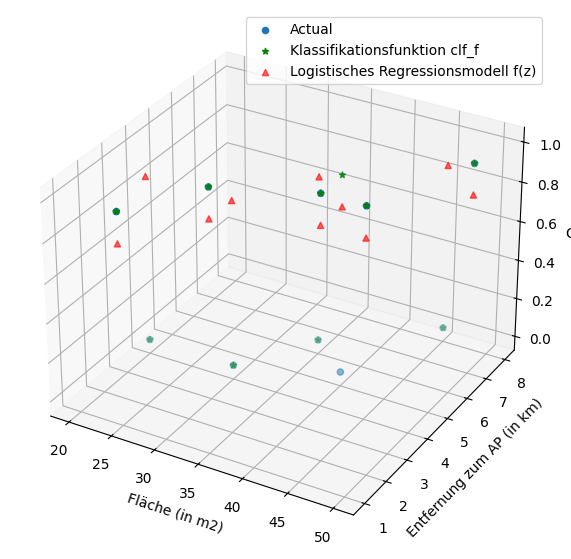

In [31]:

# Add predictions to your plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, label='Actual')
ax.scatter(x, y, predictions, color='green', label='Klassifikationsfunktion clf_f', marker='*')
ax.scatter(x, y, sigmoid_values[0], color='r', label='Logistisches Regressionsmodell f(z)', marker='^', alpha=0.6)

ax.set_xlabel('Fläche (in m2)')
ax.set_ylabel('Entfernung zum AP (in km)')
ax.set_zlabel('OK')
plt.legend()
plt.show()

Das Optimal angepasstes logistisches Regressionsmodell:
f(z) = 1 / (1 + e^-(-3.7634804954634618 + 0.25951873733186637 z1 + -1.2324707187591268 z2))
wobei -3.7634804954634618 der Achsenabschnitt und 0.25951873733186637 und -1.2324707187591268 die Koeffizienten sind.


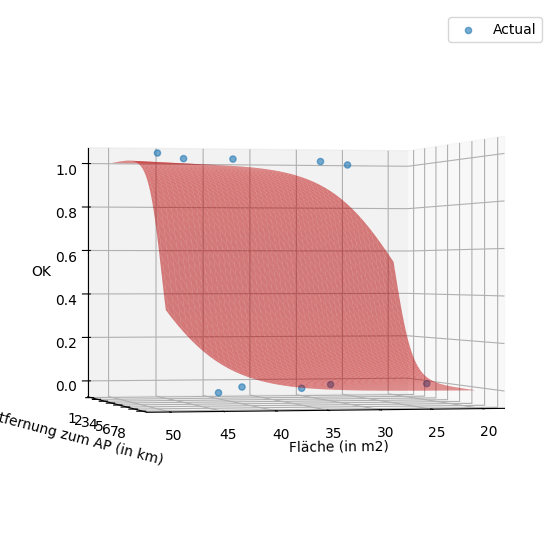

In [32]:
# Create a grid of Flaeche and Entfernung values
x_grid, y_grid = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), 
                             np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

# Calculate function value for each point in the grid
z_grid = sigmoid_funktion(model.coef_, model.intercept_, x_grid,y_grid)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(111, projection='3d')

#scatter values
ax.scatter(x, y, z, label='Actual', alpha=0.6)

# Plot the function
ax.plot_surface(x_grid, y_grid, z_grid, color="r", alpha = 0.5)

ax.set_xlabel('Fläche (in m2)')
ax.set_ylabel('Entfernung zum AP (in km)')
ax.set_zlabel('OK')
plt.legend()
ax.view_init(elev=0, azim=77)
plt.show()

See from another angle:

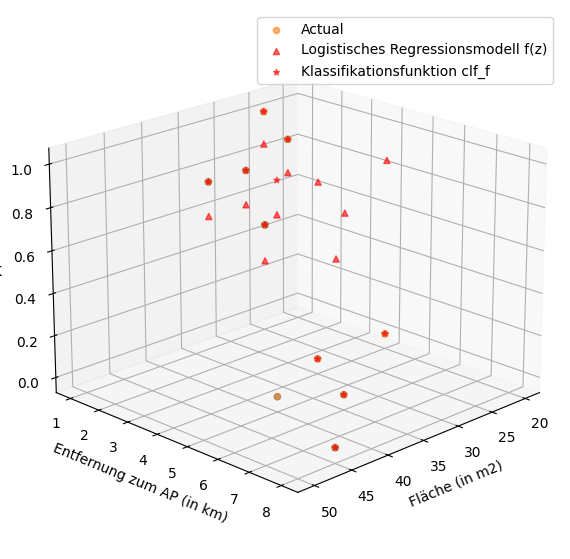

In [33]:
# Add predictions to your plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.scatter(x, y, z, label='Actual', alpha=0.6)
ax.scatter(x, y, sigmoid_values[0], color='r', label='Logistisches Regressionsmodell f(z)', marker='^', alpha=0.6)
ax.scatter(x, y, predictions, color='r', label='Klassifikationsfunktion clf_f', marker='*', alpha=0.6)

#ax.scatter(x, y, predictions, color='r', label='Predicted')
ax.set_xlabel('Fläche (in m2)')
ax.set_ylabel('Entfernung zum AP (in km)')
ax.set_zlabel('OK')
ax.view_init(elev=20, azim=45)
plt.legend()
plt.show()

### Multi-Klassen Modell: <a name="mkk"></a>

Wir haben hier ein Multiklassen Problem mit:
- **<ins>2 Klassen</ins>**: wir haben eine binäre Klassifikationsproblem (mit den Klassen 0 und 1). Das Modell erstellt mit `multi_class='ovr'` trotzdem nur eine einzige “Funktion” oder Entscheidungsgrenze. Diese trennt die Klasse 1 von der Klasse 0. Die Koeffizienten dieser Funktion können wir normal mit `clf.coef_` und den Achsenabschnitt mit `clf.intercept_` abrufen. Diese repräsentieren die Gewichte und den Bias der logistischen Funktion, die zur Klassifikation verwendet wird.

In [ ]:
# Erstellen Sie den Datensatz
D_screws = pd.DataFrame({
    'Gewicht': [11, 10, 13, 11, 11, 12, 10, 10, 9, 8],
    'Laenge': [27, 28, 29, 28, 30, 26, 29, 30, 27, 28],
    'Ok': [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
})

# Teilen Sie die Daten in Merkmale und Ziel auf
X = D_screws[['Gewicht', 'Laenge']].to_numpy()
x1 = X[:, 0]
x2 = X[:, 1]
y = D_screws['Ok']

# Trainieren Sie das Modell
clf = LogisticRegression(multi_class='ovr')
clf.fit(X, y)

# Machen Sie Vorhersagen
y_pred = clf.predict(X)

print("accuracy: ", accuracy_score(y, y_pred))
print("precision: ", precision_score(y, y_pred, zero_division=0))
print("recall: ", recall_score(y, y_pred, zero_division=0))
print("F1_score: ", f1_score(y, y_pred, zero_division=0))

def logistische_funktion(coef, intercept, z1, z2):
    print("Das Optimal angepasstes logistisches Regressionsmodell:\nf(z) = 1 / (1 + e^-("+str(intercept)+" + "+str(coef[0])+" z1 + "+str(coef[1])+" z2))")
    return 1 / (1 + np.exp(-intercept - coef[0]*z1 - coef[1]*z2))


# Berechnen Sie die Sigmoid-Werte für die z-Werte
y_pred_class0 = logistische_funktion(clf.coef_[0], clf.intercept_, x1, x2)
print(y_pred_class0)

y_pred_class1 = 1 - y_pred_class0
print(y_pred_class1)

plt.figure()

#It generates a plot object that represents the decision boundaries of an estimator (in your case, clf which is a logistic regression model)
DecisionBoundaryDisplay.from_estimator(clf,X,plot_method="pcolormesh")

plt.scatter(D_screws[y==0]["Gewicht"], D_screws[y==0]["Laenge"], facecolor='red', marker='x', label = 'OK')
plt.scatter(D_screws[y==1]["Gewicht"], D_screws[y==1]["Laenge"], facecolor='blue', marker='s', label = 'Nicht OK')

plt.plot(y, y_pred, color='green', label='Klassifikationsfunktion clf_f')
plt.plot(x1, y_pred_class0, color='r', label='Logistisches Regressionsmodell f0(z)')
plt.plot(x2, y_pred_class2, color='b', label='Logistisches Regressionsmodell f1(z)')

# Fügen Sie Achsentitel und Legende hinzu
plt.legend()

# Zeigen Sie die Abbildung an
plt.show()

- **<ins>mehr als 2 Klassen</ins>**: `multi_class='ovr'` erstellt für jede Klasse eine separate binäre Klassifikation. In diesem Fall könnten wir auf die Koeffizienten jeder einzelnen “Funktion” oder Entscheidungsgrenze mit `clf.coef_[i]` und `clf.intercept_[i]` zugreifen, wobei i der Index der Klasse ist.
Außerden, in einem Problem der Mehrklassenklassifikation muss man angeben, wie man die Genauigkeit berechnen möchte, indem man den Parameter `average` in der Funktion `precision_score`, `recall_score` und `f1_score` festlegen.nary.

   age  weight  type
0   12      12     0
1   13      34     0
2   16      30     1
3   14      15     2
4   15      39     1
5   15      13     2
6   10       5     0
7   17      56     1
8   14      11     2
9   11      23     0
[[-1.38558144  0.05187541]
 [ 0.92803097  0.23942667]
 [ 1.19405408 -0.30379739]]
[ 17.13078781 -20.98957668 -11.70697399]


<Figure size 640x480 with 0 Axes>

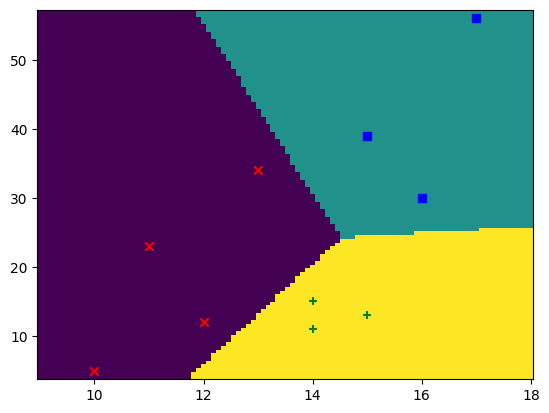

Metrics of f_Hund
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
F1_score:  [1. 1. 1.]
Metrics of f_Wolf
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
F1_score:  [1. 1. 1.]
Metrics of f_Dingo
accuracy:  1.0
precision:  [1. 1. 1.]
recall:  [1. 1. 1.]
F1_score:  [1. 1. 1.]


In [8]:
from sklearn.inspection import DecisionBoundaryDisplay

def logistische_funktion(coef, intercept, z1, z2):
    return 1 / (1 + np.exp(-intercept - coef[0]*z1 - coef[1]*z2))
    
#this line is creating a logistic regression model, training it on your data, and then storing the trained model in the variable clf.
#For that the model will use a strategy known as “one-vs-rest” (OvR) for multi-class classification
D_animals = pd.read_csv("./uebung_2_2/sl_logreg_ex_animals.csv")
print(D_animals)

X = D_animals.iloc[:, 0:-1].to_numpy()
x1 = X[:, 0]
x2 = X[:, 1]
y = D_animals.iloc[:, 2].to_numpy()

clf = LogisticRegression(multi_class='ovr').fit(X,y)
y_pred = clf.predict(X)

print(clf.coef_)
print(clf.intercept_)



y_pred_class0 = logistische_funktion(clf.coef_[0], clf.intercept_[0], x1, x2)
y_pred_class1 = logistische_funktion(clf.coef_[1], clf.intercept_[1], x1, x2)
y_pred_class2 = logistische_funktion(clf.coef_[2], clf.intercept_[2], x1, x2)


plt.figure()

#It generates a plot object that represents the decision boundaries of an estimator (in your case, clf which is a logistic regression model)
DecisionBoundaryDisplay.from_estimator(clf,X,plot_method="pcolormesh")

plt.scatter(D_animals[y==0]["age"], D_animals[y==0]["weight"], facecolor='red', marker='x', label = 'Hund')
plt.scatter(D_animals[y==1]["age"], D_animals[y==1]["weight"], facecolor='blue', marker='s', label = 'Wolf')
plt.scatter(D_animals[y==2]["age"], D_animals[y==2]["weight"], facecolor='green', marker='+', label = 'Dingo')

plt.show()

import sklearn.metrics as metrics
#models = (clf, z, y_pred)

f_dict = {
    0: 'Hund',
    1: 'Wolf',
    2: 'Dingo'
}

i=0
for i in range(3):
    print('Metrics of f_'+f_dict.get(i))
    print("accuracy: ", accuracy_score(y, y_pred))
    print("precision: ", precision_score(y, y_pred, average=None, zero_division=0))
    print("recall: ", recall_score(y, y_pred, average=None, zero_division=0))
    print("F1_score: ", f1_score(y, y_pred, average=None, zero_division=0))
    